In [7]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
admission=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/S&DS 523/Project/admission.csv')
admission.head()

,userName,major,researchExp,industryExp,specialization,toeflScore,program,department,toeflEssay,internExp,...,termAndYear,confPubs,ugCollege,gmatA,cgpa,gmatQ,cgpaScale,gmatV,univName,admit
0,143saf,Systems and Control,0,18,Robotics,112.0,MS,Instrumentation & Control,26,5.0,...,Fall - 2015,0,Dharamsinh Desai University,NaN,8.50,NaN,10,NaN,Worcester Polytechnic Institute,1
1,7790ashish,Manufacturing Engineering,0,0,NaN,NaN,MS,0,NaN,0.0,...,Fall - 2013,0,NaN,NaN,0.00,NaN,0,NaN,Worcester Polytechnic Institute,1
2,AB25,(MIS / MSIM / MSIS / MSIT),0,66,NaN,94.0,MS,Computer Engineering,21,0.0,...,Fall - 2015,0,IET DAVV,NaN,78.28,NaN,100,NaN,Worcester Polytechnic Institute,1
3,abhijitg,NaN,0,0,NaN,NaN,NaN,0,NaN,0.0,...,NaN,NaN,NaN,NaN,0.00,NaN,0,NaN,Worcester Polytechnic Institute,1
4,abhijitgang,MIS,0,0,NaN,81.0,MS,computer,NaN,0.0,...,Fall - 2011,0,Pune University,NaN,57.00,NaN,100,NaN,Worcester Polytechnic Institute,1


In [8]:
##Feature selection & Missing values processing
data=admission.copy()
data=data.drop(['userName','major','specialization','department','userProfileLink','ugCollege','gmatA','gmatQ','gmatV','termAndYear','toeflEssay','topperCgpa'],1)
data=data.dropna()

<ipython-input-8-8c0432cd89ec>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data=data.drop(['userName','major','specialization','department','userProfileLink','ugCollege','gmatA','gmatQ','gmatV','termAndYear','toeflEssay','topperCgpa'],1)


In [9]:
data.head()

,researchExp,industryExp,toeflScore,program,internExp,greV,greQ,journalPubs,greA,confPubs,cgpa,cgpaScale,univName,admit
0,0,18,112.0,MS,5.0,160.0,167.0,0,4.5,0,8.50,10,Worcester Polytechnic Institute,1
2,0,66,94.0,MS,0.0,146.0,157.0,0,3.0,0,78.28,100,Worcester Polytechnic Institute,1
4,0,0,81.0,MS,0.0,420.0,770.0,0,2.5,0,57.00,100,Worcester Polytechnic Institute,1
5,0,0,273.0,MS,0.0,410.0,1010.0,0,600.0,0,52.00,100,Worcester Polytechnic Institute,1
6,0,0,104.0,MS,0.0,150.0,161.0,0,4.5,0,62.20,100,Worcester Polytechnic Institute,1


In [5]:
def detect_outlier(s):
  Q1=np.quantile(s,.25)
  Q3=np.quantile(s,.75)
  IQR=Q3-Q1
  lower=Q1-1.5*IQR
  upper=Q3+1.5*IQR
  return np.array((s>=lower) & (s<=upper))

<Axes: >

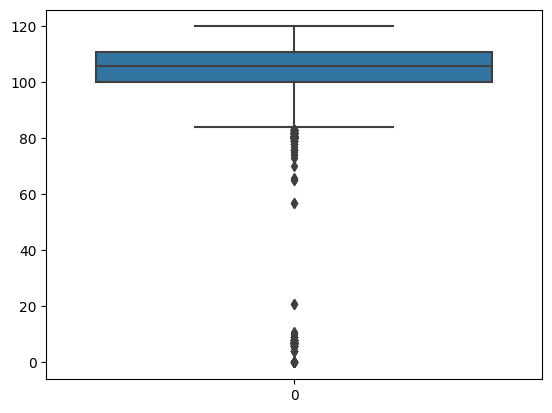

In [10]:
##Outliers processing
#TOEFL
data=data[data['toeflScore'] <=120]
sns.boxplot(data['toeflScore'])

In [11]:
data=data[detect_outlier(data['toeflScore'])]

<Axes: >

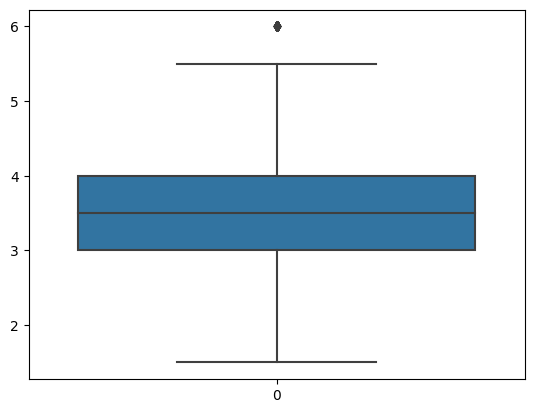

In [12]:
#greA
data=data[data['greA'] <=6]
sns.boxplot(data['greA'])

In [13]:
#min-max normalization of 'researchExp', 'industryExp', 'internExp'
data['researchExp']=(data['researchExp']-min(data['researchExp']))/(max(data['researchExp'])-min(data['researchExp']))
data['industryExp']=(data['industryExp']-min(data['industryExp']))/(max(data['industryExp'])-min(data['industryExp']))
data['internExp']=(data['internExp']-min(data['internExp']))/(max(data['internExp'])-min(data['internExp']))

In [14]:
##Data Transformation
#transform the old GRE score to the new GRE score
score=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/S&DS 523/Project/score.csv')
data=data.merge(score[['old','newQ']], how='left',left_on='greQ',right_on='old')
data=data.drop(['old'],axis=1)
data=data.merge(score[['old','newV']], how='left',left_on='greV',right_on='old')
data=data.drop(['old'],axis=1)
data.loc[data['newQ'].isnull(),'newQ']=data['greQ']
data.loc[data['newV'].isnull(),'newV']=data['greV']
data=data[data['newQ'] <=170]
data=data[data['newV'] <=170]
data=data.drop(['greV','greQ'],axis=1)

<Axes: >

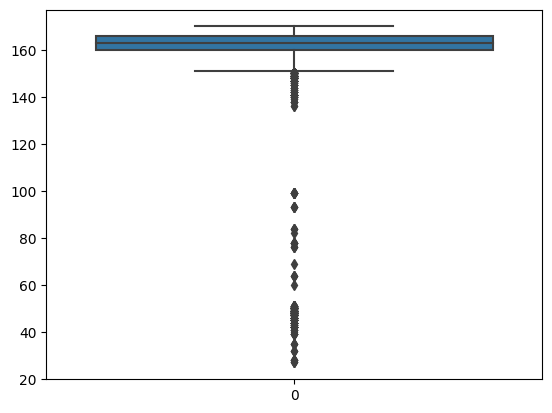

In [15]:
sns.boxplot(data['newQ'])

<Axes: >

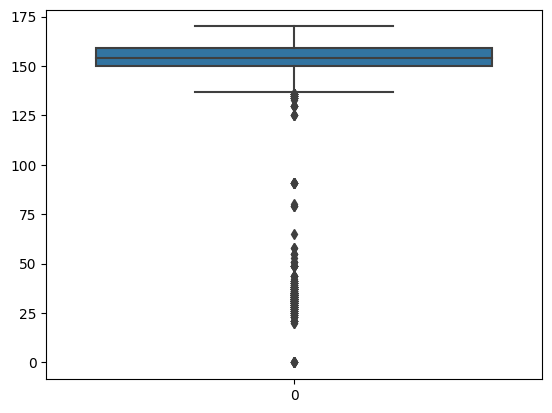

In [16]:
sns.boxplot(data['newV'])

In [17]:
data=data[detect_outlier(data['newQ'])]
data=data[detect_outlier(data['newV'])]

In [18]:
#gpa(divide GPA by its scale and generate a new value in range(0,1))
data=data[data['cgpa']<=data['cgpaScale']]
data=data[data['cgpaScale']!=0]
data['gpa']=100*data['cgpa']/data['cgpaScale']
data=data.drop(['cgpa','cgpaScale'],axis=1)

<Axes: >

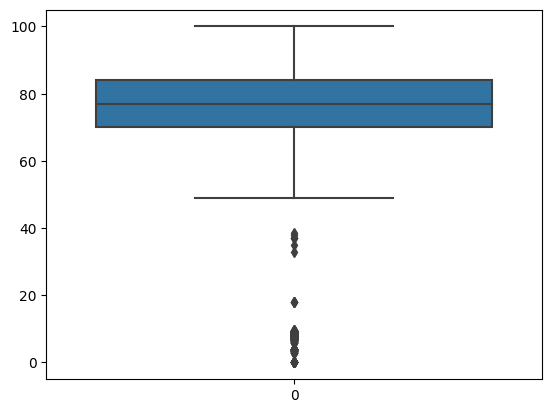

In [19]:
sns.boxplot(data['gpa'])

In [20]:
data=data[detect_outlier(data['gpa'])]

In [21]:
#program
data.loc[data['program']=='Both MS and PhD','program']='MS/PhD'

In [22]:
#generate new feature: 'greScore' and 'Pubs'
data['greScore']=data['greA']+data['newQ']+data['newV']
data['journalPubs']=data['journalPubs'].astype(int)
data['confPubs']=data['confPubs'].astype(int)
data['Pubs']=data['journalPubs']+data['confPubs']

In [23]:
data=data[['researchExp','industryExp','internExp','journalPubs','confPubs','Pubs','toeflScore','newQ','newV','greA','greScore','gpa','program','univName','admit']]
data.head()

,researchExp,industryExp,internExp,journalPubs,confPubs,Pubs,toeflScore,newQ,newV,greA,greScore,gpa,program,univName,admit
0,0.0,0.136364,0.052083,0,0,0,112.0,167.0,160.0,4.5,331.5,85.00,MS,Worcester Polytechnic Institute,1
1,0.0,0.500000,0.000000,0,0,0,94.0,157.0,146.0,3.0,306.0,78.28,MS,Worcester Polytechnic Institute,1
2,0.0,0.000000,0.000000,0,0,0,104.0,161.0,150.0,4.5,315.5,62.20,MS,Worcester Polytechnic Institute,1
3,0.0,0.000000,0.000000,0,0,0,95.0,156.0,147.0,3.0,306.0,52.00,MS,Worcester Polytechnic Institute,1
4,0.0,0.000000,0.000000,0,0,0,101.0,158.0,152.0,3.0,313.0,64.00,MS,Worcester Polytechnic Institute,1


In [24]:
data.to_csv('data_cleaned.csv')